## LGBM CV Tuning and Seed Diversification



In [ ]:
### target encoding, change objective to poisson

In [1]:
#longest sequence:
# https://stackoverflow.com/questions/40166522/find-longest-sequence-of-0s-in-the-integer-list

In [2]:
# N: Create histograms for categorical variables and group/cluster them.

# N: Use Vowpal Wabbit (vw-varinfo) or XGBoost (XGBfi) to quickly check two-way and three-way interactions.

# N: Use statistical tests to discard noisy features (eg: select k best with ANOVA F-score), Benford's Law to detect natural counts (great for logtransforms).

# ~Manually inspect the data and combine features that look similar in structure (both columns contain hashed variables) or expand categorical variables that look like hierarchical codes ("1.11125A" -> 1, 111, 25, A).

# ~Use (progressive/cross-)validation with fast algorithms or on a subset of the data to spot significant changes.

# Y: Compute stats about a row of data (nr. of 0's, nr. of NAs, max, min, mean, std)

# Y: Transforms: Log, tfidf

# Y: Numerical->Categorical: Encoding numerical variables, like 11.25 as categorical variables: eleventwentyfive

# Y: Bayesian: Encode categorical variables with its ratio of the target variable in train set.

# Y: Reduce the dimensionality / project down with tSNE, MDA, PCA, LDA, RP, RBM, kmeans or expand raw data.

# ~Genetic programming: http://gplearn.readthedocs.org/en/latest/examples.html#example-2-symbolic-tranformer to automatically create non-linear features.

# Recursive Feature Elimination: Use all features -> drop the feature that results in biggest CV gain -> repeat till no improvement

# Automation: Try to infer type of feature automatically with scripts and create feature engineering pipelines. This scales and can be used even when the features are not anonymized.

In [1]:

%matplotlib  inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
import sklearn.decomposition as sk_d
import sklearn.random_projection as sk_rp
from sklearn.externals import joblib
# from steppy.base import BaseTransformer
# from steppy.utils import get_logger

In [3]:
import time
notebookstart= time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import random
random.seed(2018)

# Models Packages
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from IPython.display import display


import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD, FastICA
from sklearn.model_selection import KFold
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE

# Gradient Boosting
import sys
sys.path.insert(0,'/home/xavierc/LightGBM/python-package/')
import lightgbm as lgb


import sys
sys.path.insert(0,'/home/xavierc/xgboost/python-package/')
import xgboost as xgb

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')

# Specify index/ target name
id_col = "ID"
target_var = "target"

# House Keeping Parameters
Debug = False
Home = False
Build_Results_csv = True # if running for first time

results = pd.DataFrame(columns = ["Rounds","Score","STDV", "LB", "Parameters"])
if Build_Results_csv is True & Home is True: results.to_csv("results.csv")
if Home is True:
    import os
    path = r"D:\My Computer\DATA\Santander"
    os.chdir(path)
    
    print("Data Load Stage")
    training = pd.read_csv('train.csv', index_col = id_col)
    if Debug is True : training = training.sample(100)
    traindex = training.index
    testing = pd.read_csv('test.csv', index_col = id_col)
    if Debug is True : testing = testing.sample(100)
    testdex = testing.index
else:
    print("Data Load Stage")
    training = pd.read_csv('/media/disk2/dataset-kaggle/santander3/train.csv', index_col = id_col)
    if Debug is True : training = training.sample(100)
    traindex = training.index
    testing = pd.read_csv('/media/disk2/dataset-kaggle/santander3/test.csv', index_col = id_col)
    if Debug is True : testing = testing.sample(100)
    testdex = testing.index

y_orig = training[target_var]
y = np.log1p(training[target_var])
training.drop(target_var,axis=1, inplace=True)
print('Train shape: {} Rows, {} Columns'.format(*training.shape))
print('Test shape: {} Rows, {} Columns'.format(*testing.shape))

print("Combine Train and Test")
df = pd.concat([training,testing],axis=0)
# del training, testing
gc.collect()
print('\nAll Data shape: {} Rows, {} Columns'.format(*df.shape))

Data Load Stage
Train shape: 4459 Rows, 4991 Columns
Test shape: 49342 Rows, 4991 Columns
Combine Train and Test

All Data shape: 53801 Rows, 4991 Columns


In [4]:
pandas.options.display.max_info_columns = 
training.info()

SyntaxError: invalid syntax (<ipython-input-4-5a55f8dd1ce6>, line 1)

In [ ]:
training.head()

In [ ]:
training.index

In [ ]:
df_agg2['non_zero_sum_orig'].shape

In [ ]:
tutu['non_zero_sum_orig'].shape

In [ ]:
toto=pd.DataFrame()
toto['ID'] = training.index
toto['target']=y_orig.values
tata=pd.DataFrame()
tata['ID'] = testing.index
tata['target']=-99999
tutu = pd.concat([toto.reset_index(drop=True), tata.reset_index(drop=True)], axis=0).reset_index(drop=True)
tutu['non_zero_sum_orig'] = df_agg2['non_zero_sum_orig'].values
tutu['diff1'] = tutu['non_zero_sum_orig'].diff()

In [ ]:
tutu.shape

In [ ]:
df_agg2['non_zero_sum_orig'].shape

In [ ]:
tutu.sort_values("ID", inplace=True)
tutu = tutu.reset_index(drop=True)
tutu['diff2'] = tutu['non_zero_sum_orig'].diff()

In [ ]:
# https://www.kaggle.com/ogrellier/santander-46-features
col46 = ['f190486d6', 'c47340d97', 'eeb9cd3aa', '66ace2992', 'e176a204a',
        '491b9ee45', '1db387535', 'c5a231d81', '0572565c2', '024c577b9',
        '15ace8c9f', '23310aa6f', '9fd594eec', '58e2e02e6', '91f701ba2',
        'adb64ff71', '2ec5b290f', '703885424', '26fc93eb7', '6619d81fc',
        '0ff32eb98', '70feb1494', '58e056e12', '1931ccfdd', '1702b5bf0',
        '58232a6fb', '963a49cdc', 'fc99f9426', '241f0f867', '5c6487af1',
        '62e59a501', 'f74e8f13d', 'fb49e4212', '190db8488', '324921c7b',
        'b43a7cfd5', '9306da53f', 'd6bb78916', 'fb0f5dbfe', '6eef030c1']

In [ ]:
for col in col46:
    print(training[col].dtypes)

In [ ]:
# from scipy.stats import entropy
# from numpy.linalg import norm
# import numpy as np

# def JSD(P, Q):
#     _P = P / norm(P, ord=1)
#     _Q = Q / norm(Q, ord=1)
#     _M = 0.5 * (_P + _Q)
#     return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))

In [ ]:
df.head()

In [ ]:
print(len(y_orig.unique()))
orig_cols = list(df.columns)
ordered_cols = sorted(orig_cols)

In [ ]:
len(orig_cols)

In [ ]:
# ordered_cols

In [592]:
df_agg1['sum_zeros_row'].min(), df_agg1['sum_zeros_row'].max(), df_agg1['sum_zeros_row'].mean()

(3004, 4992, 4915.665675359194)

## feature engineering

### agg_1

In [10]:
# df_agg1 = pd.DataFrame()
# df_agg1['Mean'] = df.mean(axis=1)
# df_agg1['Median'] = df.median(axis=1)
# df_agg1['Mode'] = df.mode(axis=1)
# df_agg1['Max'] = df.max(axis=1)
# df_agg1['Var'] = df.var(axis=1)
# df_agg1['Std'] = df.std(axis=1)
# df_agg1['number_of_different'] = df.nunique(axis=1)
# df_agg1['col_non_zero_count'] = df.astype(bool).sum(axis=1) 
# df_agg1['sum_zeros_row'] = (df == 0).astype(int).sum(axis=1)
# df_agg1['geometric_mean'] = df.apply(lambda x: np.exp(np.log(x[x>0]).mean()), axis=1)


In [17]:
# import itertools,operator
# # r = max((list(y) for (x,y) in itertools.groupby((enumerate(A)),operator.itemgetter(1)) if x == 0), key=len)
# # print(r[0][0]) # prints 12
# # print(r[-1][0]) # prints 19

# def greater_0_maxseq(row):
#     rk=max([len(list(y)) for (c,y) in itertools.groupby(row.values) if c==0])
#     return rk
# def greater_0_minseq(row):
#     rk=min([len(list(y)) for (c,y) in itertools.groupby(row.values) if c==0])
#     return rk
# def greater_0_meanseq(row):
#     rk=np.mean([len(list(y)) for (c,y) in itertools.groupby(row.values) if c==0])
#     return rk
# def greater_0_stdseq(row):
#     rk=np.std([len(list(y)) for (c,y) in itertools.groupby(row.values) if c==0])
#     return rk
# def greater_0_lenseq(row):
#     rk=len([len(list(y)) for (c,y) in itertools.groupby(row.values) if c==0])
#     return rk

# df_agg1['long0maxseq'] = df.apply(greater_0_maxseq,axis=1)
# df_agg1['long0minseq'] = df.apply(greater_0_minseq,axis=1)
# df_agg1['long0meanseq'] = df.apply(greater_0_meanseq,axis=1)
# df_agg1['long0stdseq'] = df.apply(greater_0_stdseq,axis=1)
# df_agg1['long0lenseq'] = df.apply(greater_0_lenseq,axis=1)

# # df['long0maxseq_ord'] = df[ordered_cols].apply(greater_0_maxseq,axis=1)
# # df['long0minseq_ord'] = df[ordered_cols].apply(greater_0_minseq,axis=1)
# # df['long0meanseq_ord'] = df[ordered_cols].apply(greater_0_minseq,axis=1)
# # df['long0stdseq_ord'] = df[ordered_cols].apply(greater_0_minseq,axis=1)
# # df['long0lenseq_ord'] = df[ordered_cols].apply(greater_0_minseq,axis=1)

In [ ]:
# df_agg1.to_pickle('/media/disk2/dataset-kaggle/santander3/df_agg1_001.pickle')
df_agg1 = pd.read_pickle('/media/disk2/dataset-kaggle/santander3/df_agg1_001.pickle')

In [ ]:
df_agg1.head(4)

### agg_2

In [22]:
# def aggregate_row(row, suffix='_orig'):
#     non_zero_values = row.iloc[row.nonzero()]
#     aggs = {'non_zero_mean'+suffix: non_zero_values.mean(),
#             'non_zero_std'+suffix: non_zero_values.std(),
#             'non_zero_max'+suffix: non_zero_values.max(),
#             'non_zero_min'+suffix: non_zero_values.min(),
#             'non_zero_sum'+suffix: non_zero_values.sum(),
#             'non_zero_skewness'+suffix: skew(non_zero_values),
#             'non_zero_kurtosis'+suffix: kurtosis(non_zero_values),
#             'non_zero_median'+suffix: non_zero_values.median(),
#             'non_zero_q1'+suffix: np.percentile(non_zero_values, q=25),
#             'non_zero_q3'+suffix: np.percentile(non_zero_values, q=75),
#             'non_zero_log_mean'+suffix: np.log1p(non_zero_values).mean(),
#             'non_zero_log_std'+suffix: np.log1p(non_zero_values).std(),
#             'non_zero_log_max'+suffix: np.log1p(non_zero_values).max(),
#             'non_zero_log_min'+suffix: np.log1p(non_zero_values).min(),
#             'non_zero_log_sum'+suffix: np.log1p(non_zero_values).sum(),
#             'non_zero_log_skewness'+suffix: skew(np.log1p(non_zero_values)),
#             'non_zero_log_kurtosis'+suffix: kurtosis(np.log1p(non_zero_values)),
#             'non_zero_log_median'+suffix: np.log1p(non_zero_values).median(),
#             'non_zero_log_q1'+suffix: np.percentile(np.log1p(non_zero_values), q=25),
#             'non_zero_log_q3'+suffix: np.percentile(np.log1p(non_zero_values), q=75),
#             'non_zero_count_row'+suffix: non_zero_values.count(),
#             'non_zero_fraction'+suffix: non_zero_values.count() / row.count()
#             }
#     return pd.Series(aggs)


# df_agg2 = df.apply(aggregate_row, axis=1)

In [ ]:
# df_agg2.to_pickle('/media/disk2/dataset-kaggle/santander3/df_agg2_001.pickle')
df_agg2 = pd.read_pickle('/media/disk2/dataset-kaggle/santander3/df_agg2_001.pickle')

In [ ]:
df_agg2.shape

In [ ]:
df_agg2.head(4)

In [26]:
# def aggregate_row(row, suffix='_0'):
#     non_zero_values = row.iloc[row.nonzero()]
#     aggs = {'non_zero_mean'+suffix: non_zero_values.mean(),
#             'non_zero_std'+suffix: non_zero_values.std(),
#             'non_zero_max'+suffix: non_zero_values.max(),
#             'non_zero_min'+suffix: non_zero_values.min(),
#             'non_zero_sum'+suffix: non_zero_values.sum(),
# #             'non_zero_skewness'+name: skew(non_zero_values),
# #             'non_zero_kurtosis'+name: kurtosis(non_zero_values),
# #             'non_zero_median'+name: non_zero_values.median(),
# #             'non_zero_q1'+name: np.percentile(non_zero_values, q=25),
# #             'non_zero_q3'+name: np.percentile(non_zero_values, q=75),
# #             'non_zero_log_mean'+name: np.log1p(non_zero_values).mean(),
# #             'non_zero_log_std'+name: np.log1p(non_zero_values).std(),
# #             'non_zero_log_max'+name: np.log1p(non_zero_values).max(),
# #             'non_zero_log_min'+name: np.log1p(non_zero_values).min(),
# #             'non_zero_log_sum'+name: np.log1p(non_zero_values).sum(),
# #             'non_zero_log_skewness'+name: skew(np.log1p(non_zero_values)),
# #             'non_zero_log_kurtosis'+name: kurtosis(np.log1p(non_zero_values)),
# #             'non_zero_log_median'+name: np.log1p(non_zero_values).median(),
# #             'non_zero_log_q1'+name: np.percentile(np.log1p(non_zero_values), q=25),
# #             'non_zero_log_q3'+name: np.percentile(np.log1p(non_zero_values), q=75),
#             'non_zero_count_row'+suffix: non_zero_values.count(),
# #             'non_zero_fraction'+name: non_zero_values.count() / row.count()
#             }
#     return pd.Series(aggs)

# df_agg2 = pd.DataFrame()

# for i in range(0,712,7):
#     df_newn = df.iloc[:,i:i+7]
#     df_new = df_newn.apply(aggregate_row, suffix=str(i), axis=1)
#     df_agg2 = pd.concat([df_agg2, df_new], axis=1)

In [27]:
# df_agg3.shape

In [59]:
### try doing agg by 7 days

### agg_3

In [28]:
# df_agg3 = pd.DataFrame()

# iii = [28*6,28*12,28*24,28*36]
# for a in iii:
#     bbb = int(4991/a)*a
#     for i in range(0,bbb,a):
#         df_newn = df.iloc[:,i:i+a]
#         df_new = pd.DataFrame()
#         df_new['geo_'+str(a)+'_'+str(i)] = df_newn.apply(lambda x: np.exp(np.log(x[x>0]).mean()), axis=1)
#         df_agg3 = pd.concat([df_agg3, df_new], axis=1)

In [70]:
# def kmeans(X_Tr,Xte):
#     flist = [x for x in X_Tr.columns if not x in ['ID','target']]
#     flist_kmeans = []
#     for ncl in range(2,11):
#         cls = KMeans(n_clusters=ncl)
#         cls.fit_predict(X_train[flist].values)
#         X_Tr['kmeans_cluster_'+str(ncl)] = cls.predict(X_Tr[flist].values)
#         Xte['kmeans_cluster_'+str(ncl)] = cls.predict(Xte[flist].values)
#         flist_kmeans.append('kmeans_cluster_'+str(ncl))
#     print(flist_kmeans)
    
#     return X_Tr,Xte

In [ ]:
df_agg1.shape, df_agg2.shape

In [5]:
# df = pd.concat([df, df_agg, df_agg2], axis=1)

In [6]:
# # https://www.kaggle.com/ajarmstrong/separate-aggregates-for-dense-and-sparse-features

# df_agg4 = pd.DataFrame()

# train_zeros = pd.DataFrame({'Percent_zero':((training.values)==0).mean(axis=0),
#                            'Column' : training.columns})

# high_vol_columns = train_zeros['Column'][train_zeros['Percent_zero'] > 0.70].values
# mid_vol_columns = train_zeros['Column'][(train_zeros['Percent_zero'] <= 0.70) & (train_zeros['Percent_zero'] >= 0.30)].values
# low_vol_columns = train_zeros['Column'][train_zeros['Percent_zero'] < 0.30].values

### selection of features for test and train

In [7]:
# from mlbox.preprocessing import Reader, Drift_thresholder
# # os.environ["KERAS_BACKEND"] = "tensorflow"

# import os
# os.environ["THEANO_FLAGS"] = "device=cuda2,floatX=float32"

path_santander = '/media/disk2/dataset-kaggle/santander3/'

# paths = [path_santander+"train.csv", path_santander+"test.csv"]
# target_name = "target"

# rd = Reader(sep = ",", to_path='save')
# df = rd.train_test_split(paths, target_name)
# dft = Drift_thresholder(to_path='save')
# df = dft.fit_transform(df)

In [8]:
# path_santander = '/media/disk2/dataset-kaggle/santander3/'
# drift_df = pd.read_csv(path_santander+'drift_002.txt', header=None, sep=' =')
# drift_col = drift_df.iloc[-1500:,0].values


drift_col = np.array(col46)

NameError: name 'col46' is not defined

### target encoding:

In [10]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=10,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior
    """
    assert len(trn_series) == len(target)
#     assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [717]:
train = pd.DataFrame()
test = pd.DataFrame()

for col in col46:
    trn, tst = target_encode(training[col], 
                         testing[col], 
                         target=y, 
                         min_samples_leaf=5,
                         smoothing=10,
                         noise_level=0.1)
    train[col+'_cat_enc'] = trn
    test[col+'_cat_enc'] = tst

In [718]:
test.shape

(49342, 40)

### tfidf

In [261]:
df_agg4 = pd.DataFrame()
df_agg4['all_numerical'] = df[col46].astype(str).apply(' '.join, axis=1)

In [262]:
df_agg4.head()

,all_numerical
ID,
000d6aaf2,1866666.66 0.0 700000.0 0.0 0.0 0.0 0.0 0.0 40...
000fbd867,0.0 0.0 2225000.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
0027d6b71,0.0 0.0 0.0 5500000.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
0028cbf45,2000000.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
002a68644,0.0 8000000.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5400...


In [318]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
count_vectorizer = TfidfVectorizer(
#                                         stop_words=stopwords.words('russian'), 
#                                         ngram_range=(1, 2),
                                        min_df=1,
                                        max_features=50000)

In [319]:
tfidf_counts = count_vectorizer.fit_transform(df_agg4['all_numerical'])

/home/xavierc/.local/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [320]:
tfidf_counts.shape

(53801, 20009)

In [265]:
# help(tfidf_counts)

In [266]:
#### concatenate all 0 and all non values

In [267]:
### trend from spciy

In [776]:
y_orig[3]

2000000.0

In [775]:
for i in range(24):
    toto = training.iloc[i,:]
    tata = toto.iloc[toto.nonzero()].values==y_orig[i]
    print(tata.sum())

0
0
0
3
0
2
0
0
0
0
0
0
0
3
0
0
4
1
0
4
0
0
0
0


In [786]:
    toto = training.iloc[5,:]
    toto.iloc[toto.nonzero()].values==y_orig[5]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [789]:
toto.iloc[toto.nonzero()].values.shape,y_orig[5]

((761,), 2800000.0)

(array([243.,   6.,   4.,   0.,   0.,  33.,   1.,  32.,   1.,  64.,   0.,
         34.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  32.,   0.,   0.,
         32.,   0.,  32.,  32.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,  32.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   2.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  32.,   0.,
          0.,   5.,  64.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,  32.,   0.,   0.,   0.,  32.,   0.,   0.,   0.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

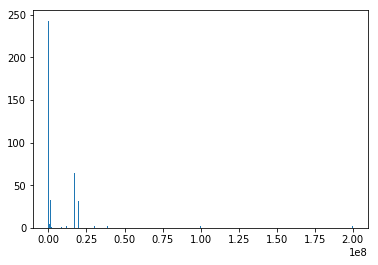

In [790]:
plt.hist(toto.iloc[toto.nonzero()].values, bins = 800)

In [243]:
df.head()

,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
ID,,,,,,,,,,,,,,,,,,,,,
000d6aaf2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000fbd867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2200000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0027d6b71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0028cbf45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
002a68644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [357]:
### decompose the index
dfindex = pd.DataFrame()
dfindex['D'] = df.index
# dfindex.sort_values("D", inplace=True)
dfindex = dfindex['D'].str.extract('([A-Za-z\d])([A-Za-z\d])([A-Za-z\d])([A-Za-z\d])([A-Za-z\d])([A-Za-z\d])([A-Za-z\d])([A-Za-z\d])([A-Za-z\d])', expand = True)
dfindex.columns = ['D_'+str(i) for i in range(9)]
dfindex.index = df.index

In [358]:
from sklearn.preprocessing import LabelEncoder

for feature in list(dfindex.columns):
    print(feature)
#     print(f'Transforming {feature}...')
    encoder = LabelEncoder()

    dfindex[feature] = encoder.fit_transform(dfindex[feature].astype(str))

#     dic = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

# #     print(dic['nan'])

#     dic['nan']=-999

#     test[feature+"_le"]=test[feature].astype(str).map(dic).fillna(-999)

D_0
D_1
D_2
D_3
D_4
D_5
D_6
D_7
D_8


In [359]:
# dfindex = dfindex[['D_7', 'D_8']]

### decompositions

In [73]:
# PERC_TRESHOLD = 0.98   ### Percentage of zeros in each feature ###
# N_COMP = 100            ### Number of decomposition components ###

# # print("\nStart decomposition process...")
# # print("PCA")
# # pca = PCA(n_components=N_COMP, random_state=17)
# # pca_results_train = pca.fit_transform(df[orig_cols])
# # # pca_results_test = pca.transform(X_test)
# # # print(pca.explained_variance_ratio_)

# # print("Append decomposition components to datasets...")
# # for i in range(1, N_COMP + 1):
# #     df['pca_' + str(i)] = pca_results_train[:, i - 1]

# print("tSVD")
# tsvd = TruncatedSVD(n_components=N_COMP, random_state=17)
# tsvd_results_train = tsvd.fit_transform(df[orig_cols])
# # tsvd_results_test = tsvd.transform(X_test)

# print("Append decomposition components to datasets...")
# for i in range(1, N_COMP + 1):
#     df['tsvd_' + str(i)] = tsvd_results_train[:, i - 1]

# # print("ICA")
# # ica = FastICA(n_components=N_COMP, random_state=17)
# # ica_results_train = ica.fit_transform(X_train)
# # ica_results_test = ica.transform(X_test)

# # print("GRP")
# # grp = GaussianRandomProjection(n_components=N_COMP, eps=0.1, random_state=17)
# # grp_results_train = grp.fit_transform(X_train)
# # grp_results_test = grp.transform(X_test)

# # N_COMP = 50

# # print("SRP")
# # srp = SparseRandomProjection(n_components=N_COMP, dense_output=True, random_state=17)
# # srp_results_train = srp.fit_transform(df)
# # # srp_results_test = srp.transform(X_test)

# # print("Append decomposition components to datasets...")
# # for i in range(1, N_COMP + 1):
# #     df['srp_' + str(i)] = srp_results_train[:, i - 1]



# # print("Append decomposition components to datasets...")
# # for i in range(1, N_COMP + 1):
# #     X_train['pca_' + str(i)] = pca_results_train[:, i - 1]
# #     X_test['pca_' + str(i)] = pca_results_test[:, i - 1]
    
# #     X_train['ica_' + str(i)] = ica_results_train[:, i - 1]
# #     X_test['ica_' + str(i)] = ica_results_test[:, i - 1]

# #     X_train['tsvd_' + str(i)] = tsvd_results_train[:, i - 1]
# #     X_test['tsvd_' + str(i)] = tsvd_results_test[:, i - 1]

# #     X_train['grp_' + str(i)] = grp_results_train[:, i - 1]
# #     X_test['grp_' + str(i)] = grp_results_test[:, i - 1]

# #     X_train['srp_' + str(i)] = srp_results_train[:, i - 1]
# #     X_test['srp_' + str(i)] = srp_results_test[:, i - 1]

tSVD
Append decomposition components to datasets...


In [245]:
df.shape

(53801, 4991)

In [75]:
# from sklearn.cluster import DBSCAN
# from sklearn import metrics
# from sklearn.preprocessing import StandardScaler

# X = StandardScaler().fit_transform(df[orig_cols])

# # Compute DBSCAN
# db = DBSCAN(eps=0.3, min_samples=10, n_jobs=-1).fit(X)
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True
# labels = db.labels_

In [76]:
# len(set(labels))

In [77]:
# # Number of clusters in labels, ignoring noise if present.
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# print('Estimated number of clusters: %d' % n_clusters_)
# # print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# # print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# # print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# # print("Adjusted Rand Index: %0.3f"
# #       % metrics.adjusted_rand_score(labels_true, labels))
# # print("Adjusted Mutual Information: %0.3f"
# #       % metrics.adjusted_mutual_info_score(labels_true, labels))
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X, labels))

### find potential categorical variables

## cleanup  #0 colomns 

In [78]:
# Columns to drop because there is no variation in training set
zero_std_cols = training.columns[training.std() == 0]
training.drop(zero_std_cols, axis=1, inplace=True)
df.drop(zero_std_cols, axis=1, inplace=True)
print(">> Removed {} constant columns".format(len(zero_std_cols)))

# Removing duplicate columns
# Taken from: https://www.kaggle.com/scirpus/santander-poor-mans-tsne
colsToRemove = []
colsScaned = []
dupList = {}
columns = training.columns
for i in range(len(columns)-1):
    v = training[columns[i]].values
    dupCols = []
    for j in range(i+1,len(columns)):
        if np.array_equal(v, training[columns[j]].values):
            colsToRemove.append(columns[j])
            if columns[j] not in colsScaned:
                dupCols.append(columns[j]) 
                colsScaned.append(columns[j])
                dupList[columns[i]] = dupCols
colsToRemove = list(set(colsToRemove))

print(">> Dropped {} duplicate columns".format(len(colsToRemove)))

>> Removed 256 constant columns
>> Dropped 5 duplicate columns


In [79]:
training.drop(colsToRemove, axis=1, inplace=True)
df.drop(colsToRemove, axis=1, inplace=True)

In [80]:
colsToRemove

['912836770', 'f8d75792f', 'acc5b709d', 'd60ddde1b', 'f333a5f60']

In [82]:
df.to_pickle('/media/disk2/dataset-kaggle/santander3/df003.pickle')

In [83]:
# df = pd.read_csv('/media/disk2/dataset-kaggle/santander3/df001.csv')

In [305]:
df_cat = df[col46]

In [306]:
df_cat.columns = [i+str('_cat') for i in col46]

## Modeling Stage

In [719]:
len(['tdidf'+str(i) for i in range(100)])

100

In [720]:
# X_train = df.loc[traindex,:]
# X_test = df.loc[testdex,:]

In [721]:
traindex.shape

(4459,)

In [13]:
import scipy

feature_names = np.hstack([
#     list(drift_col),
#     list(train.columns),
    list(df_agg1.columns),
    list(df_agg2.columns),
#     ['tdidf'+str(i) for i in range(tfidf_counts.shape[1])],
#     list(df_cat.columns)
    list(dfindex.columns),
])
print('Number of features:', len(feature_names))



X_train = scipy.sparse.hstack([
#             df.loc[traindex,list(drift_col)],
            train,
            df_agg1.loc[traindex,:],
            df_agg2.loc[traindex,:],
#             tfidf_counts[:4459,:],
#             df_cat.loc[traindex,:],
            dfindex.loc[traindex,:],

            
    ], format='csr')
print('Xtrain shape:', X_train.shape)

X_test = scipy.sparse.hstack([
#             df.loc[testdex,list(drift_col)],
            test,
            df_agg1.loc[testdex,:],
            df_agg2.loc[testdex,:],
#             tfidf_counts[4459:,:],
#             df_cat.loc[testdex,:],
            dfindex.loc[testdex,:],

            
    ], format='csr')
print('X_test shape:', X_test.shape)

NameError: name 'df_agg1' is not defined

In [723]:
feature_names

array(['f190486d6', 'c47340d97', 'eeb9cd3aa', '66ace2992', 'e176a204a',
       '491b9ee45', '1db387535', 'c5a231d81', '0572565c2', '024c577b9',
       '15ace8c9f', '23310aa6f', '9fd594eec', '58e2e02e6', '91f701ba2',
       'adb64ff71', '2ec5b290f', '703885424', '26fc93eb7', '6619d81fc',
       '0ff32eb98', '70feb1494', '58e056e12', '1931ccfdd', '1702b5bf0',
       '58232a6fb', '963a49cdc', 'fc99f9426', '241f0f867', '5c6487af1',
       '62e59a501', 'f74e8f13d', 'fb49e4212', '190db8488', '324921c7b',
       'b43a7cfd5', '9306da53f', 'd6bb78916', 'fb0f5dbfe', '6eef030c1',
       'f190486d6_cat_enc', 'c47340d97_cat_enc', 'eeb9cd3aa_cat_enc',
       '66ace2992_cat_enc', 'e176a204a_cat_enc', '491b9ee45_cat_enc',
       '1db387535_cat_enc', 'c5a231d81_cat_enc', '0572565c2_cat_enc',
       '024c577b9_cat_enc', '15ace8c9f_cat_enc', '23310aa6f_cat_enc',
       '9fd594eec_cat_enc', '58e2e02e6_cat_enc', '91f701ba2_cat_enc',
       'adb64ff71_cat_enc', '2ec5b290f_cat_enc', '703885424_cat_enc',
    

In [724]:
# X_train = X_train[X_train.columns[5001:]]
# X_train.shape

In [725]:
# vocab = df_feature[:1000]['ID'].tolist()

# LGBM Dataset
lgtrain = lgb.Dataset(X_train,y ,feature_name=list(feature_names))
# print("Starting LightGBM. Train shape: {}, Test shape: {}".format(df.loc[testdex,:].shape,test_df.shape))
# print("Feature Num: ",len(vocab))
# del df; 
gc.collect();

In [726]:
print("Light Gradient Boosting Regressor: ")
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    "learning_rate": 0.01,
    "num_leaves": 200,
    "feature_fraction": 0.50,
    "bagging_fraction": 0.50,
    'bagging_freq': 4,
    "max_depth": 6,
    "reg_alpha": 0.3,
    "reg_lambda": 0.1,
    'max_bin': 50,
    #"min_split_gain":0.2,
    "min_child_weight":5,
    
    
#         'objective': 'regression',
#         'num_leaves': 58,
#         'subsample': 0.6143,
#         'colsample_bytree': 0.6453,
#         'min_split_gain': np.power(10, -2.5988),
#         'reg_alpha': np.power(10, -2.2887),
#         'reg_lambda': np.power(10, 1.7570),
#         'min_child_weight': np.power(10, -0.1477),
#         'verbose': -1,
#         'seed': 3,
#         'boosting_type': 'gbdt',
#         'max_depth': -1,
#         'learning_rate': 0.05,
    
    'zero_as_missing':True,
    'is_sparse' : False,
    
    'device' : "gpu",
    'gpu_platform_id' : 0,
    'gpu_device_id' : 2,
    'num_threads' : 1,
    
#         'num_threads' : 45,
    
    'gpu_use_dp' : True,
    
                }

Light Gradient Boosting Regressor: 


## Cross-Validation
**Hand Tuning:**

In [727]:
# help(lgb.cv)

In [728]:
modelstart= time.time()
# Find Optimal Parameters / Boosting Rounds
lgb_cv = lgb.cv(
    params = lgbm_params,
    train_set = lgtrain,
    num_boost_round=2000,
    stratified=False,
#     categorical_feature=list(dfindex.columns),
    nfold = 3,
    verbose_eval=50,
    seed = 23,
    early_stopping_rounds=75)

optimal_rounds = np.argmin(lgb_cv['rmse-mean'])
best_cv_score = min(lgb_cv['rmse-mean'])

print("\nOptimal Round: {}\nOptimal Score: {} + {}".format(
    optimal_rounds,best_cv_score,lgb_cv['rmse-stdv'][optimal_rounds]))

results = results.append({"Rounds": optimal_rounds,
                          "Score": best_cv_score,
                          "STDV": lgb_cv['rmse-stdv'][optimal_rounds],
                          "LB": None,
                          "Parameters": lgbm_params}, ignore_index=True)

[50]	cv_agg's rmse: 1.45842 + 0.0157916
[100]	cv_agg's rmse: 1.29749 + 0.0136402
[150]	cv_agg's rmse: 1.20429 + 0.0111295
[200]	cv_agg's rmse: 1.14757 + 0.0098238
[250]	cv_agg's rmse: 1.1129 + 0.00828819
[300]	cv_agg's rmse: 1.09022 + 0.00766895
[350]	cv_agg's rmse: 1.07491 + 0.00772591
[400]	cv_agg's rmse: 1.06428 + 0.00697784
[450]	cv_agg's rmse: 1.05572 + 0.00609063
[500]	cv_agg's rmse: 1.04955 + 0.00580594
[550]	cv_agg's rmse: 1.04411 + 0.00571227
[600]	cv_agg's rmse: 1.03936 + 0.00536424
[650]	cv_agg's rmse: 1.03575 + 0.00449454
[700]	cv_agg's rmse: 1.033 + 0.00387872
[750]	cv_agg's rmse: 1.03027 + 0.00362542
[800]	cv_agg's rmse: 1.02728 + 0.00377728
[850]	cv_agg's rmse: 1.02504 + 0.00385336
[900]	cv_agg's rmse: 1.02273 + 0.00362902
[950]	cv_agg's rmse: 1.02079 + 0.00381878
[1000]	cv_agg's rmse: 1.01871 + 0.00441812
[1050]	cv_agg's rmse: 1.01724 + 0.00417823
[1100]	cv_agg's rmse: 1.0156 + 0.00408234
[1150]	cv_agg's rmse: 1.01467 + 0.00432491
[1200]	cv_agg's rmse: 1.01376 + 0.00381

In [729]:
np.argmin(lgb_cv['rmse-mean'])

1840

In [730]:
lgb_reg = lgb.train(
    lgbm_params,
    train_set = lgtrain,
    num_boost_round = optimal_rounds + 1,
    verbose_eval=50,
#     categorical_feature=list(dfindex.columns),

)

Lightgbm_pred = lgb_reg.predict(X_test)


Text(0.5,1,'Light GBM Feature Importance')

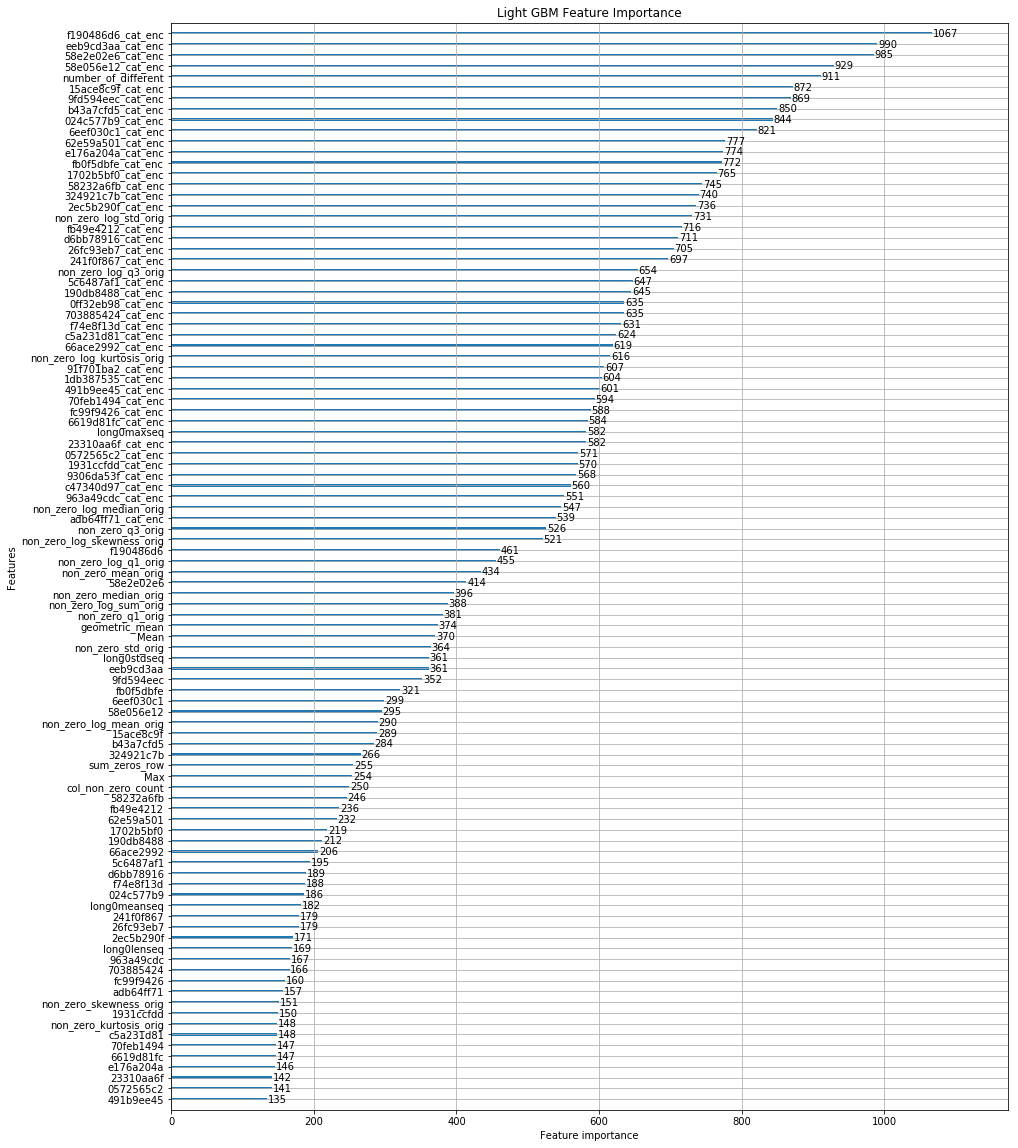

In [731]:
fig, ax = plt.subplots(figsize=(15, 20))
lgb.plot_importance(lgb_reg, max_num_features=100, ax=ax)
plt.title("Light GBM Feature Importance")

In [732]:
Lightgbm_pred

array([14.87462989, 15.44721544, 14.4157188 , ..., 14.64088103,
       11.69272418, 15.01973036])

In [733]:
import sys
sys.path.insert(0,'/home/xavierc/xgboost/python-package/')
import xgboost as xgb

In [734]:


dev_X, val_X, dev_y, val_y = train_test_split(X_train, y, test_size = 0.2, random_state = 42)

params = {'objective': 'reg:linear', 
          'eval_metric': 'rmse', 
          'eta': 0.005, 
          'fold': 10,
          'max_depth': 5, 
          'gamma' : 10,
          'min_child_weight': 50,
          'subsample': 0.7, 
          'colsample_bytree': 0.7, 
          'alpha':0, 
          'silent': True, 
          'random_state':5,
#               'gpu_id' : 0,
# #               'max_bin' : 16,
#               'tree_method' : 'gpu_exact',
         }
# {'objective': 'reg:linear','eval_metric': 'rmse','eta': 0.005,'max_depth': 15,'subsample': 0.7,'colsample_bytree': 0.5,'alpha':0,'random_state':42,'silent': True}

tr_data = xgb.DMatrix(dev_X, dev_y, feature_names=feature_names)
va_data = xgb.DMatrix(val_X, val_y, feature_names=feature_names)


watchlist = [(tr_data, 'train'), (va_data, 'valid')]

model_xgb = xgb.train(params, 
                      tr_data, 
                      20000, 
                      watchlist, 
                      maximize=False, 
                      early_stopping_rounds = 30, 
                      verbose_eval=100)

#     dtest = xgb.DMatrix(test_X)
#     xgb_pred_y = np.expm1(model_xgb.predict(dtest, ntree_limit=model_xgb.best_ntree_limit))



[0]	train-rmse:14.0319	valid-rmse:14.0212
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[100]	train-rmse:8.57249	valid-rmse:8.57586
[200]	train-rmse:5.28779	valid-rmse:5.30071
[300]	train-rmse:3.33467	valid-rmse:3.35465
[400]	train-rmse:2.20537	valid-rmse:2.23249
[500]	train-rmse:1.58878	valid-rmse:1.62231
[600]	train-rmse:1.27882	valid-rmse:1.3183
[700]	train-rmse:1.13613	valid-rmse:1.17907
[800]	train-rmse:1.07213	valid-rmse:1.11767
[900]	train-rmse:1.04185	valid-rmse:1.09041
[1000]	train-rmse:1.02622	valid-rmse:1.07677
[1100]	train-rmse:1.01716	valid-rmse:1.06961
[1200]	train-rmse:1.01185	valid-rmse:1.06561
[1300]	train-rmse:1.00842	valid-rmse:1.06324
[1400]	train-rmse:1.00593	valid-rmse:1.06174
[1500]	train-rmse:1.00326	valid-rmse:1.06007
[1600]	train-rmse:1.00079	valid-rmse:1.05882
[1700]	train-rmse:0.997683	valid-rmse:1.05737
Stopping. Best iteration:
[1756]	train-rmse:0.996716	vali

In [700]:
[0]	train-rmse:14.0319	valid-rmse:14.0211
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[100]	train-rmse:8.5832	valid-rmse:8.58305
[200]	train-rmse:5.31954	valid-rmse:5.33046
[300]	train-rmse:3.39448	valid-rmse:3.42198
[400]	train-rmse:2.2984	valid-rmse:2.34695
[500]	train-rmse:1.71454	valid-rmse:1.78883
[600]	train-rmse:1.4347	valid-rmse:1.53016
[700]	train-rmse:1.31771	valid-rmse:1.42091
[800]	train-rmse:1.27124	valid-rmse:1.3772
[900]	train-rmse:1.25196	valid-rmse:1.35968
[1000]	train-rmse:1.24592	valid-rmse:1.3529
[1100]	train-rmse:1.24226	valid-rmse:1.35004
[1200]	train-rmse:1.24117	valid-rmse:1.3488
[1300]	train-rmse:1.24087	valid-rmse:1.34825
[1400]	train-rmse:1.24076	valid-rmse:1.34799
[1500]	train-rmse:1.24072	valid-rmse:1.34785
[1600]	train-rmse:1.24071	valid-rmse:1.34778
[1700]	train-rmse:1.2407	valid-rmse:1.34773
[1800]	train-rmse:1.2407	valid-rmse:1.34771
[1900]	train-rmse:1.2407	valid-rmse:1.3477
[1999]	train-rmse:1.2407	valid-rmse:1.34769

SyntaxError: invalid syntax (<ipython-input-700-7b4784c0dd99>, line 1)

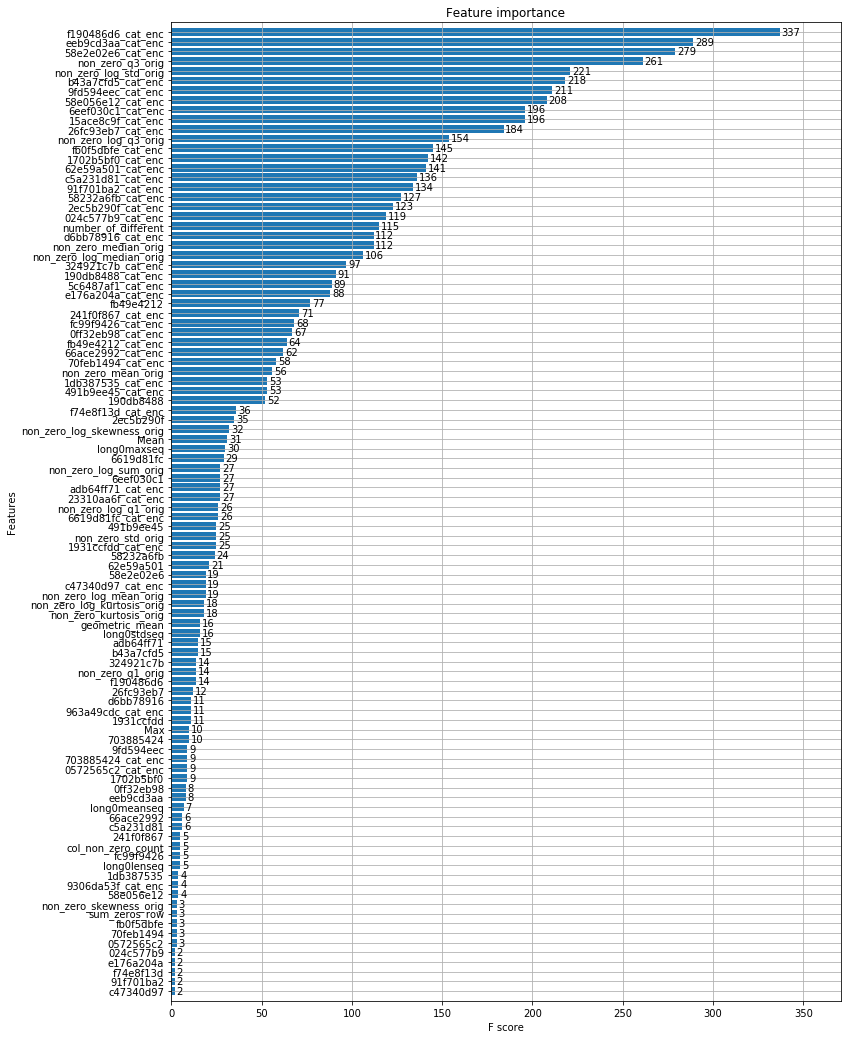

In [735]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model_xgb, max_num_features=100, height=0.8, ax=ax)
plt.show()

In [736]:
# params = {'objective': 'reg:linear', 
#           'eval_metric': 'rmse', 
#           'eta': 0.01, 
#           'fold': 10,
#           'max_depth': 15, 
#           'gamma' : 10,
#           'min_child_weight': 50,
# #           'subsample': 0.5, 
# #           'colsample_bytree': 0.5, 
#           'alpha':0, 
#           'silent': True, 
#           'random_state':5,
# #               'gpu_id' : 0,
# # #               'max_bin' : 16,
# #               'tree_method' : 'gpu_exact',
#          }


trall_data = xgb.DMatrix(X_train, y)
model_xgb = xgb.cv(params, 
                      trall_data, 
                      2000, 
#                       watchlist, 
                      maximize=False, 
                      early_stopping_rounds = 30, 
                      verbose_eval=100)



[0]	train-rmse:14.0297+0.00539423	test-rmse:14.0297+0.0107847
[100]	train-rmse:8.57333+0.00323388	test-rmse:8.57276+0.0114315
[200]	train-rmse:5.28844+0.00194811	test-rmse:5.29223+0.00931547
[300]	train-rmse:3.33371+0.00118897	test-rmse:3.34603+0.00811515
[400]	train-rmse:2.20325+0.00255289	test-rmse:2.22851+0.00554938
[500]	train-rmse:1.58445+0.00423077	test-rmse:1.627+0.00281695
[600]	train-rmse:1.27286+0.00500706	test-rmse:1.33268+0.00133778
[700]	train-rmse:1.1299+0.00579078	test-rmse:1.20246+0.0032881
[800]	train-rmse:1.0675+0.00620583	test-rmse:1.14834+0.0051263
[900]	train-rmse:1.03945+0.00683879	test-rmse:1.12582+0.00593762
[1000]	train-rmse:1.02569+0.00681072	test-rmse:1.1157+0.00683198
[1100]	train-rmse:1.01794+0.00680269	test-rmse:1.11075+0.00722318
[1200]	train-rmse:1.01281+0.00658488	test-rmse:1.10772+0.00765974
[1300]	train-rmse:1.00935+0.00657354	test-rmse:1.10586+0.00783103
[1400]	train-rmse:1.00676+0.00669926	test-rmse:1.10442+0.00792618
[1500]	train-rmse:1.00474+0.006

In [345]:
# help(model_xgb)

In [737]:
all_data = xgb.DMatrix(X_train, y, feature_names=feature_names)

all_data_xgb = xgb.train(params, 
                      all_data,  
                      maximize=False,
                      num_boost_round = 1079,
                      verbose_eval=100)


In [738]:
feature_names

array(['f190486d6', 'c47340d97', 'eeb9cd3aa', '66ace2992', 'e176a204a',
       '491b9ee45', '1db387535', 'c5a231d81', '0572565c2', '024c577b9',
       '15ace8c9f', '23310aa6f', '9fd594eec', '58e2e02e6', '91f701ba2',
       'adb64ff71', '2ec5b290f', '703885424', '26fc93eb7', '6619d81fc',
       '0ff32eb98', '70feb1494', '58e056e12', '1931ccfdd', '1702b5bf0',
       '58232a6fb', '963a49cdc', 'fc99f9426', '241f0f867', '5c6487af1',
       '62e59a501', 'f74e8f13d', 'fb49e4212', '190db8488', '324921c7b',
       'b43a7cfd5', '9306da53f', 'd6bb78916', 'fb0f5dbfe', '6eef030c1',
       'f190486d6_cat_enc', 'c47340d97_cat_enc', 'eeb9cd3aa_cat_enc',
       '66ace2992_cat_enc', 'e176a204a_cat_enc', '491b9ee45_cat_enc',
       '1db387535_cat_enc', 'c5a231d81_cat_enc', '0572565c2_cat_enc',
       '024c577b9_cat_enc', '15ace8c9f_cat_enc', '23310aa6f_cat_enc',
       '9fd594eec_cat_enc', '58e2e02e6_cat_enc', '91f701ba2_cat_enc',
       'adb64ff71_cat_enc', '2ec5b290f_cat_enc', '703885424_cat_enc',
    

In [739]:
test_data = xgb.DMatrix(X_test, feature_names=feature_names)
XGB_pred = all_data_xgb.predict(test_data)

In [740]:
XGB_pred

array([14.961752, 14.946731, 14.356345, ..., 14.924409, 12.035576,
       15.4104  ], dtype=float32)

In [351]:


# mean_sub = np.expm1(sub_preds.mean(axis=1).rename(target_var))
# mean_sub.index = testdex

In [742]:
submission = pd.DataFrame()
submission['ID'] = testdex
submission['target'] = np.expm1((XGB_pred+Lightgbm_pred)/2) #np.expm1((XGB_pred+Lightgbm_pred)/2) #(np.expm1(XGB_pred)+np.expm1(Lightgbm_pred)/2)
submission.to_csv('/media/disk2/dataset-kaggle/santander3/submission/'+'submission_lgbxgb_006.csv', index=False)

In [743]:
submission

,ID,target
0,000137c73,3.012228e+06
1,00021489f,3.980718e+06
2,0004d7953,1.769188e+06
3,00056a333,6.934603e+06
4,00056d8eb,2.101753e+06
5,0005fc190,2.901711e+06
6,000787e86,2.348804e+06
7,0008510a0,2.908144e+06
8,000895faf,4.408261e+06
9,000986fba,3.257219e+06


In [676]:
submission['target'][0]

3989875.293139759

In [677]:
y_orig.values

array([38000000.,   600000., 10000000., ...,  2800000., 10000000.,
       20000000.])

In [510]:
train_preds = np.expm1(all_data_xgb.predict(all_data))
train_preds

array([2852078. , 2267661.5, 2133768. , ..., 2758853.5, 1181137. ,
       6613131. ], dtype=float32)

In [511]:
test_preds = np.expm1(all_data_xgb.predict(test_data))
test_preds

array([2677233.5 , 2454617.5 , 1840930.4 , ..., 2801679.  ,  225078.78,
       4325501.5 ], dtype=float32)

In [469]:
y_orig_int = [int(i) for i in list(y_orig.values)]

In [505]:
from scipy.optimize import fmin_powell

def rmsle(y_true, y_pred):
    errors = (np.log1p(y_true) - np.log1p(y_pred)) ** 2
    return np.sqrt(np.mean(errors))

def eval_wrapper(yhat, y):  
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)   
    return rmsle(yhat, y)



def apply_offset(data, bin_offset, sv, scorer=eval_wrapper):
    # data has the format of pred=0, offset_pred=1, labels=2 in the first dim
    data[1, data[0].astype(int)==sv] = data[0, data[0].astype(int)==sv] + bin_offset
    score = scorer(data[1], data[2])
    return score

# train offsets 
offsets = np.unique(np.array(y_orig_int))
offset_train_preds = np.vstack((train_preds, train_preds, y_orig.values))
for j in offsets:
    print(j)
    train_offset = lambda x: -apply_offset(offset_train_preds, x, j)
    offsets[j] = fmin_powell(train_offset, j)  




30000
Optimization terminated successfully.
         Current function value: -1.254598
         Iterations: 1
         Function evaluations: 13


IndexError: index 30000 is out of bounds for axis 0 with size 1413

In [504]:
j

30000

(array([10., 16., 18., ...,  0.,  0., 15.]),
 array([   66128.421875  ,    82000.64728795,    97872.87270089, ...,
        22255499.54917411, 22271371.77458705, 22287244.        ]),
 <a list of 1400 Patch objects>)

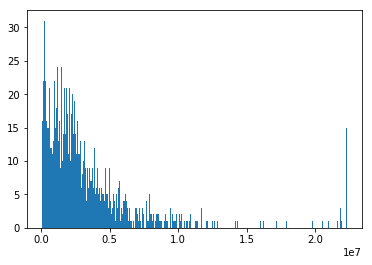

In [485]:
plt.hist(train_preds, bins=1400)

In [482]:
maxnew−minnewmaxold−minold⋅(v−maxold)+maxnew

(30000.0, 40000000.0, 66128.42, 22287244.0)

In [509]:
maxnew = train_preds.max()
minnew = train_preds.min()
maxold = y_orig.max()
minold = y_orig.min()

new_train_preds = (maxnew-minnew)/(maxold-minold)*(train_preds-maxold)+maxnew
new_train_preds

array([1635048., 1310144., 1235706., ..., 1583220.,  706096., 3725986.],
      dtype=float32)

(array([10., 16., 18., ...,  0.,  0., 15.]),
 array([   86214.        ,    95038.08142857,   103862.16285714, ...,
        12422279.83714286, 12431103.91857143, 12439928.        ]),
 <a list of 1400 Patch objects>)

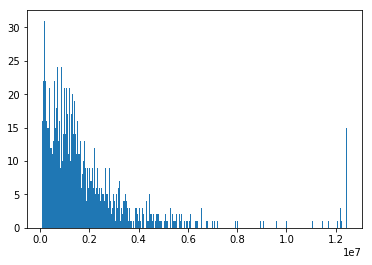

In [516]:
plt.hist(new_train_preds, bins=1400)

In [515]:
eval_wrapper(y_orig.values,train_preds)

1.20565583300503

In [466]:
# apply offsets to test
data = np.vstack((test_preds, test_preds, test_preds))
for j in y_orig_int:
    data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j] 

final_test_preds = np.round(np.clip(data[1], 30000.0, 40000000.0)).astype(int)


array([2677234, 2454618, 1840930, ..., 2801679,  225079, 4325502])

In [513]:
rmsle(train_preds, y_orig)

1.2545982147522805

In [514]:
rmsle(new_train_preds, y_orig)

1.37073037777833

## Final Model and Seed Diversification
Out-of-Fold Methods are very poplular in public kernels at the moment. This is a alternative that operates in a similar way. Instead of explicitly dividing the data, the randomized seed changes the row and column subsampling choice which also forces the model to do without some data to achieve a more diverse, robust prediction.

In [14]:
# Best Parameters
final_model_params = results.iloc[results["Score"].idxmin(),:]["Parameters"]
optimal_rounds = results.iloc[results["Score"].idxmin(),:]["Rounds"]
print("Parameters for Final Models:\n",final_model_params)
print("Score: {} +/- {}".format(results.iloc[results["Score"].idxmin(),:]["Score"],results.iloc[results["Score"].idxmin(),:]["STDV"]))
print("Rounds: ", optimal_rounds)

In [15]:
allmodelstart= time.time()
# Run Model with different Seeds
multi_seed_pred = dict()
all_feature_importance_df  = pd.DataFrame()

all_seeds = [27,22,300,401]
for seeds_x in all_seeds:
    modelstart= time.time()
    print("Seed: ", seeds_x,)
    # Go Go Go
    final_model_params["seed"] = seeds_x
    lgb_reg = lgb.train(
        final_model_params,
        lgtrain,
        num_boost_round = optimal_rounds + 1,
        verbose_eval=200)

    # Feature Importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = vocab
    fold_importance_df["importance"] = lgb_reg.feature_importance()
    all_feature_importance_df = pd.concat([all_feature_importance_df, fold_importance_df], axis=0)

    multi_seed_pred[seeds_x] =  list(lgb_reg.predict(test_df))
    print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))
    print("###########################################################################################")
    del lgb_reg

cols = all_feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index
best_features = all_feature_importance_df.loc[all_feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8,10))
sns.barplot(x="importance", y="feature", 
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')
print("All Model Runtime: %0.2f Minutes"%((time.time() - allmodelstart)/60))

# To DataFrame
sub_preds = pd.DataFrame.from_dict(multi_seed_pred).replace(0,0.000001)
del multi_seed_pred; gc.collect();

# Correlation Plot
f, ax = plt.subplots(figsize=[8,6])
sns.heatmap(sub_preds.corr(),
            annot=True, fmt=".2f",cbar_kws={'label': 'Percentage %'},cmap="plasma",ax=ax)
ax.set_title("Correlation Plot for Seed Diversified Models")
plt.show()

In [18]:
# Take Mean over Seed prediction
mean_sub = np.expm1(sub_preds.mean(axis=1).rename(target_var))
mean_sub.index = testdex

# Submit
mean_sub.to_csv('mean_sub_ep{}_sc{}.csv'.format(optimal_rounds,round(best_cv_score,5))
            ,index = True, header=True)
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))
mean_sub.head()